# 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

import xgboost as xgb

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from pathlib import Path

## 1.2. Loading data

In [2]:
FOLDER_PATH = Path("../data/processed")

In [3]:
df_train = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "train.csv", low_memory=False)
df_test = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "test.csv", low_memory=False)

In [4]:
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

# 2. Machine learning model

In [5]:
seed = 42

In [6]:
#X_train = df_train.drop(columns=["Date", "Sales", "Customers", "Open", "Store"])
X_train = df_train.drop(columns=["Date", "Sales", "Customers"])
y_train = df_train[["Sales"]]

In [7]:
#X_test = df_test.drop(columns=["Date", "Sales", "Customers", "Open", "Store"])
X_test = df_test.drop(columns=["Date", "Sales", "Customers"])
y_test = df_test[["Sales"]]

In [8]:
assert len(X_train.columns) == len(X_test.columns), 'Different columns between X_train and X_test'

## 4.1. XGBoost

In [9]:
def root_mean_square_percentage_error(y_true, y_pred):
    rmspe = np.sqrt(np.mean(((y_true.values.reshape(len(y_true)) - y_pred) / y_true.values.reshape(len(y_true)))**2))
    return rmspe

def model_performance(y_true, y_pred):
    rmspe = root_mean_square_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return pd.DataFrame({'RMSPE': rmspe,
                         'RMSE': rmse,
                         'MAPE': mape},
                         index=[0])

In [10]:
reg_xgb = xgb.XGBRegressor(n_estimators = 5000, enable_categorical=True, random_state=seed)
reg_xgb.fit(X=X_train, y=y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred_xgb = reg_xgb.predict(X=X_test)

In [12]:
model_performance(y_true=y_test, y_pred=y_pred_xgb)

,RMSPE,RMSE,MAPE
0,0.17151,969.407654,0.107813


### 4.1.2. Feature importances filtering

<Axes: xlabel='importances', ylabel='None'>

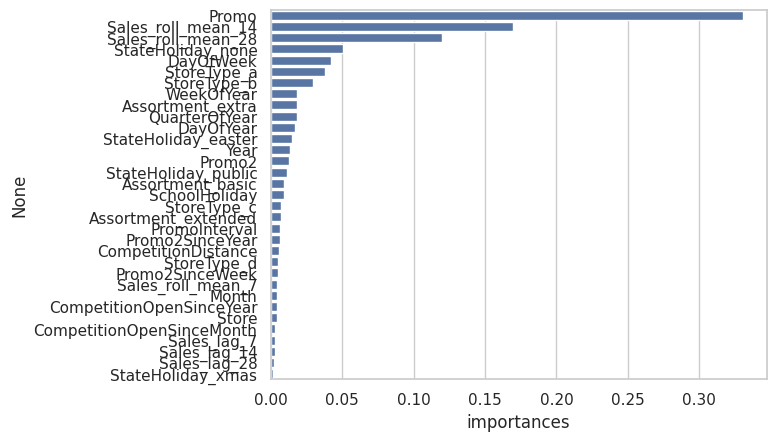

In [13]:
fi = pd.DataFrame(data=reg_xgb.feature_importances_,
                  index=reg_xgb.feature_names_in_,
                  columns=['importances']).sort_values(by='importances', ascending=False)

sns.barplot(data=fi, x='importances', y=fi.index)

In [50]:
top10feat = fi.iloc[:15,:].index

In [51]:
top10feat

Index(['Promo', 'Sales_roll_mean_14', 'Sales_roll_mean_28',
       'StateHoliday_none', 'DayOfWeek', 'StoreType_a', 'StoreType_b',
       'WeekOfYear', 'Assortment_extra', 'QuarterOfYear', 'DayOfYear',
       'StateHoliday_easter', 'Year', 'Promo2', 'StateHoliday_public'],
      dtype='object')

In [52]:
reg_xgb_filtered = xgb.XGBRegressor(n_estimators = 5000, enable_categorical=True, random_state=seed)
reg_xgb_filtered.fit(X=X_train[top10feat], y=y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)

In [53]:
y_pred_xgb_filtered = reg_xgb_filtered.predict(X=X_test[top10feat])
model_performance(y_true=y_test, y_pred=y_pred_xgb_filtered)

,RMSPE,RMSE,MAPE
0,0.273666,1360.525146,0.175481


### 4.1.3. Early stopping

In [ ]:
reg_xgb_es = xgb.XGBRegressor(n_estimators = 5000,
                              learning_rate = 0.01,
                              enable_categorical=True,
                              early_stopping_rounds = 100,
                              #eval_metric = rmspe_sklearn,
                              random_state=seed)

reg_xgb_es.fit(X=X_train[top10feat],
               y=y_train,
               eval_set = [(X_test[top10feat], y_test)],
               #custom_metric = rmspe_xgb,
               verbose=100)

[0]	validation_0-rmse:2913.88722
[50]	validation_0-rmse:2003.67454
[100]	validation_0-rmse:1527.77098
[150]	validation_0-rmse:1298.41546
[200]	validation_0-rmse:1195.81076
[250]	validation_0-rmse:1149.32097
[300]	validation_0-rmse:1128.53547
[350]	validation_0-rmse:1116.28742
[400]	validation_0-rmse:1109.74432
[450]	validation_0-rmse:1104.94024
[500]	validation_0-rmse:1099.97945
[550]	validation_0-rmse:1096.15698
[600]	validation_0-rmse:1088.93862
[650]	validation_0-rmse:1080.09286
[700]	validation_0-rmse:1076.95851
[750]	validation_0-rmse:1073.00738
[800]	validation_0-rmse:1069.91389
[850]	validation_0-rmse:1062.54069
[900]	validation_0-rmse:1056.48546
[950]	validation_0-rmse:1051.06595
[1000]	validation_0-rmse:1047.01446
[1050]	validation_0-rmse:1043.96570
[1100]	validation_0-rmse:1041.22438
[1150]	validation_0-rmse:1039.28156
[1200]	validation_0-rmse:1038.53913
[1250]	validation_0-rmse:1037.55172
[1300]	validation_0-rmse:1036.37235
[1350]	validation_0-rmse:1035.71242
[1400]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)

In [87]:
y_pred_xgb = reg_xgb_es.predict(X=X_test[top10feat])
model_performance(y_true=y_test, y_pred=y_pred_xgb)

,RMSPE,RMSE,MAPE
0,0.166476,1030.466797,0.109456


### 4.1.3. Hyperparameter tunning

In [ ]:
reg_xgb_tun = xgb.XGBRegressor(enable_categorical=True, random_state=seed)

In [112]:
tscv = TimeSeriesSplit(n_splits=3)

In [113]:
xgb_space = {
    "n_estimators": Integer(100, 5000),
    "max_depth": Integer(2,10),
    "learning_rate": Real(0.001, 1, prior="log-uniform"),
    "subsample": Real(0.05, 1.0),
    "colsample_bytree": Real(0.1, 1.0),
    #"colsample_bylevel": Real(0.5, 1.0),
    #"colsample_bynode": Real(0.5, 1.0),
    "reg_alpha": Real(0.0, 10.0),
    #"reg_lambda": Real(0.0, 10.0),
    #"gamma": Real(0.0, 10.0)
}

reg_xgb_opt = BayesSearchCV(estimator=reg_xgb_tun, search_spaces=xgb_space,
                            scoring="neg_root_mean_squared_error", n_iter=10,
                            cv=tscv, random_state=seed, n_jobs=-1)


In [114]:
reg_xgb_opt.fit(X=X_train, y=y_train)

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None...
                             'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.05, high=1.0, prior='uniform', transform='normalize')})

In [115]:
reg_xgb_opt.best_score_

np.float64(-2809.0736490885415)

In [ ]:
xgb_clf_opt.best_score_
0.3056546208516953
xgb_clf_opt.best_params_
OrderedDict([('colsample_bytree', 0.5890627609212813),
             ('learning_rate', 0.5754766135782297),
             ('max_depth', 6),
             ('n_estimators', 4205),
             ('reg_alpha', 3.2405998228437367),
             ('subsample', 0.0985778259931992)])
y_pred_xgb = xgb_clf_opt.predict(X=X_valid[features])
y_pred_proba_xgb = xgb_clf_opt.predict_proba(X=X_valid[features])
roc_xgb = roc_auc_score(y_score=y_pred_proba_xgb[:,1], y_true=y_valid)
4.3. Results

## Outras hipóteses
- treinar cada loja separadamente?

## 4.2. Validation